# MNIST - Machine Learning

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split

df_train = pd.read_csv('train.csv', dtype=np.float32)

# Exploring the data

In [12]:
print(df_train.describe())
print(df_train.info())
print(df_train.isna().sum())

              label   pixel0   pixel1   pixel2   pixel3   pixel4   pixel5  \
count  42000.000000  42000.0  42000.0  42000.0  42000.0  42000.0  42000.0   
mean       4.456643      0.0      0.0      0.0      0.0      0.0      0.0   
std        2.887730      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.000000      0.0      0.0      0.0      0.0      0.0      0.0   
25%        2.000000      0.0      0.0      0.0      0.0      0.0      0.0   
50%        4.000000      0.0      0.0      0.0      0.0      0.0      0.0   
75%        7.000000      0.0      0.0      0.0      0.0      0.0      0.0   
max        9.000000      0.0      0.0      0.0      0.0      0.0      0.0   

        pixel6   pixel7   pixel8  ...      pixel774      pixel775  \
count  42000.0  42000.0  42000.0  ...  42000.000000  42000.000000   
mean       0.0      0.0      0.0  ...      0.219286      0.117095   
std        0.0      0.0      0.0  ...      6.312890      4.633819   
min        0.0      0.0      0

# Preprocessing data: Train and Test

In [38]:
targets_numpy = df_train.label.values
features_numpy = df_train.loc[:,df_train.columns != "label"].values / 255

features_train, features_test, targets_train, targets_test = train_test_split(features_numpy, targets_numpy, test_size = 0.3, random_state = 20)

featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor)

array([1., 0., 1., ..., 7., 6., 9.], dtype=float32)

In [14]:
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor)

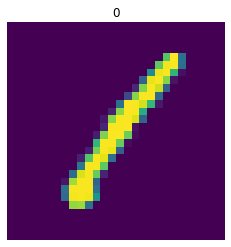

In [131]:
plt.imshow(features_numpy[0].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[0]))
plt.savefig('graph.png')
plt.show()

# Build CNN model

In [18]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()

        self.max_pool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()

        self.max_pool2 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(32 * 4 * 4, 10)

    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)

        out = self.max_pool1(out)

        out = self.cnn2(out)
        out = self.relu2(out)

        out = self.max_pool2(out)

        out = out.view(out.size(0), -1)

        out = self.fc1(out)

        return out

batch_size = 100
n_iteration = 2500
num_epochs = n_iteration / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

model = CNNModel()

error = nn.CrossEntropyLoss()

learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Training model

In [21]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        optimizer.zero_grad()

        outputs = model(train)

        loss = error(outputs, labels)

        loss.backward()

        optimizer.step()

        count += 1

        if count % 50 == 0:
            correct = 0
            total = 0
            for image, label in test_loader:

                test = Variable(image.view(100, 1, 28, 28))

                outputs = model(test)

                predicted = torch.max(outputs.data, 1)[1]

                total += len(label)

                correct += (predicted == label).sum()

            accuracy = 100 * correct / float(total)

            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            print(f'Iteration: {count}  Loss: {loss.data}  Accuracy: {accuracy} %')

Iteration: 500  Loss: 0.04325567185878754  Accuracy: 97.75396728515625 %
Iteration: 1000  Loss: 0.08435753732919693  Accuracy: 97.88095092773438 %
Iteration: 1500  Loss: 0.0640360563993454  Accuracy: 97.92857360839844 %
Iteration: 2000  Loss: 0.04169295355677605  Accuracy: 98.21428680419922 %


# Evaluating the fit of the model

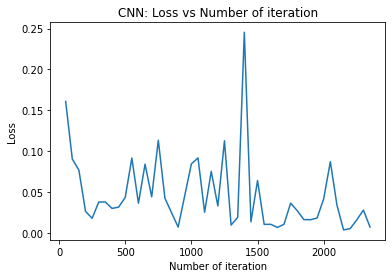

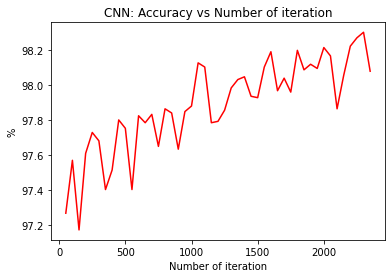

In [23]:
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("%")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

# Test data

In [61]:
def prediction(model_nn, data_loader):
    prediction = []
    for img, l in data_loader:

        test_dt = Variable(img.view(100, 1, 28, 28))

        output = model_nn(test_dt)

        predict = torch.max(output.data, 1)[1]
        prediction.append(predict)

    return prediction

In [62]:
df_test = pd.read_csv('test.csv', dtype=np.float32)
df_test['label'] = [0] * 28000

targets_test_predict = df_test.label.values
features_test_predict = df_test.loc[:,df_test.columns != "label"].values / 255

featuresTest = torch.from_numpy(features_test_predict)
targetsTest = torch.from_numpy(targets_test_predict).type(torch.LongTensor)

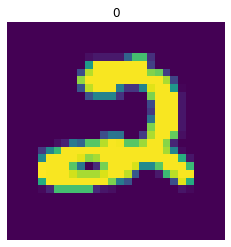

In [72]:
plt.imshow(features_test_predict[0].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[0]))
plt.savefig('graph1.png')
plt.show()

In [64]:
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

In [98]:
submission = prediction(model, test_loader)
submission

[tensor([2, 0, 9, 9, 3, 7, 0, 3, 0, 3, 5, 7, 4, 0, 4, 3, 3, 1, 9, 0, 9, 1, 1, 5,
         7, 4, 2, 7, 1, 7, 7, 5, 4, 2, 6, 2, 5, 5, 1, 6, 7, 7, 4, 9, 8, 7, 8, 2,
         6, 7, 6, 8, 8, 3, 8, 2, 1, 2, 2, 9, 4, 1, 7, 0, 0, 0, 1, 9, 0, 1, 6, 5,
         8, 8, 2, 8, 9, 9, 2, 3, 5, 4, 1, 0, 9, 2, 4, 3, 6, 7, 2, 0, 6, 6, 1, 4,
         3, 9, 7, 4]),
 tensor([0, 9, 2, 0, 7, 3, 0, 5, 0, 8, 0, 0, 4, 7, 1, 7, 1, 1, 3, 3, 3, 7, 2, 8,
         6, 3, 8, 7, 8, 4, 3, 5, 6, 0, 0, 0, 3, 1, 5, 6, 5, 3, 4, 5, 5, 8, 7, 7,
         2, 8, 4, 3, 5, 6, 5, 3, 7, 5, 7, 8, 3, 0, 4, 5, 1, 2, 7, 6, 3, 0, 2, 7,
         8, 6, 1, 3, 7, 4, 1, 2, 4, 8, 5, 2, 4, 9, 2, 1, 6, 0, 6, 1, 4, 9, 6, 0,
         9, 7, 6, 9]),
 tensor([1, 9, 0, 9, 9, 0, 8, 4, 6, 2, 0, 9, 3, 6, 3, 2, 1, 6, 3, 4, 2, 3, 1, 2,
         2, 0, 4, 6, 1, 0, 0, 4, 9, 1, 7, 3, 2, 3, 8, 6, 8, 6, 2, 8, 5, 5, 4, 8,
         3, 4, 9, 7, 1, 3, 8, 4, 5, 1, 4, 5, 6, 3, 3, 5, 7, 0, 6, 8, 3, 1, 6, 0,
         6, 3, 9, 3, 1, 5, 8, 4, 0, 9, 2, 0, 5, 3, 7, 1, 9, 9, 

In [127]:
sub = [t.numpy() for t in submission]
answer = list(np.array(sub).reshape((28000, 1)))
results = list(map(int, answer))

df_submission = pd.DataFrame({'ImageId': list(np.arange(1, 28001, 1)), 'Label': results})

In [128]:
df_submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [129]:
df_submission.to_csv('submission.csv', index=False)